In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

#print the head
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.607130e+12,12-05-20 00:00,BTC/USDT,18650.51,18699.17,18631.23,18669.43,179.214158,3.345011e+06,3347
1,1.607120e+12,12-04-20 23:00,BTC/USDT,18665.31,18841.00,18601.50,18650.52,2948.572604,5.522612e+07,64625
2,1.607120e+12,12-04-20 22:00,BTC/USDT,18807.09,18875.27,18565.31,18665.30,2805.203431,5.257989e+07,84979
3,1.607120e+12,12-04-20 21:00,BTC/USDT,18962.52,18988.75,18725.60,18806.41,3265.941089,6.156124e+07,66152
4,1.607110e+12,12-04-20 20:00,BTC/USDT,19038.73,19045.34,18880.00,18962.53,2390.289129,4.533668e+07,50160


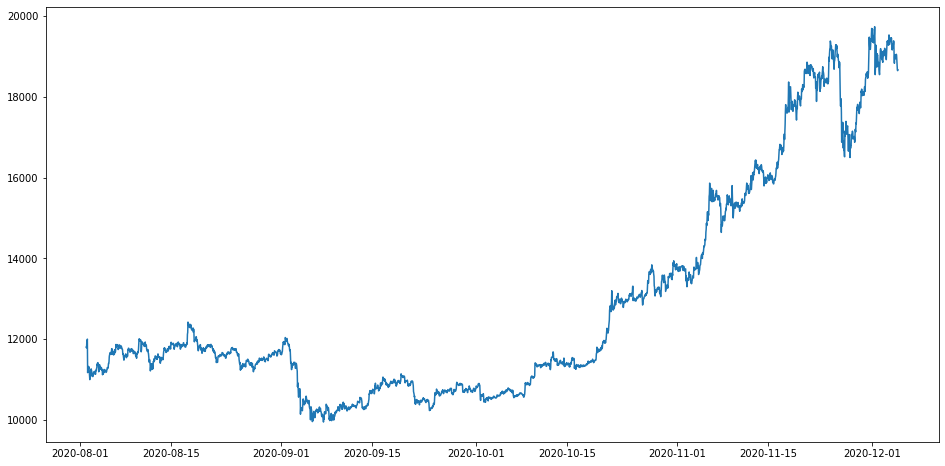

In [2]:
#setting index as date
df.keys()
df['date'] = pd.to_datetime(df.date)
df.index = df['date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

midpoint = 2300
lookback = 60

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:midpoint,:]
valid = dataset[midpoint:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(lookback,len(train)):
    x_train.append(scaled_data[i-lookback:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting values, using past lookback from the train data
inputs = new_data[len(new_data) - len(valid) - lookback:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(lookback,inputs.shape[0]):
    X_test.append(inputs[i-lookback:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

2240/2240 - 36s - loss: 3.3834e-04


In [4]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

476.092633601289

/Users/calvinkinateder/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


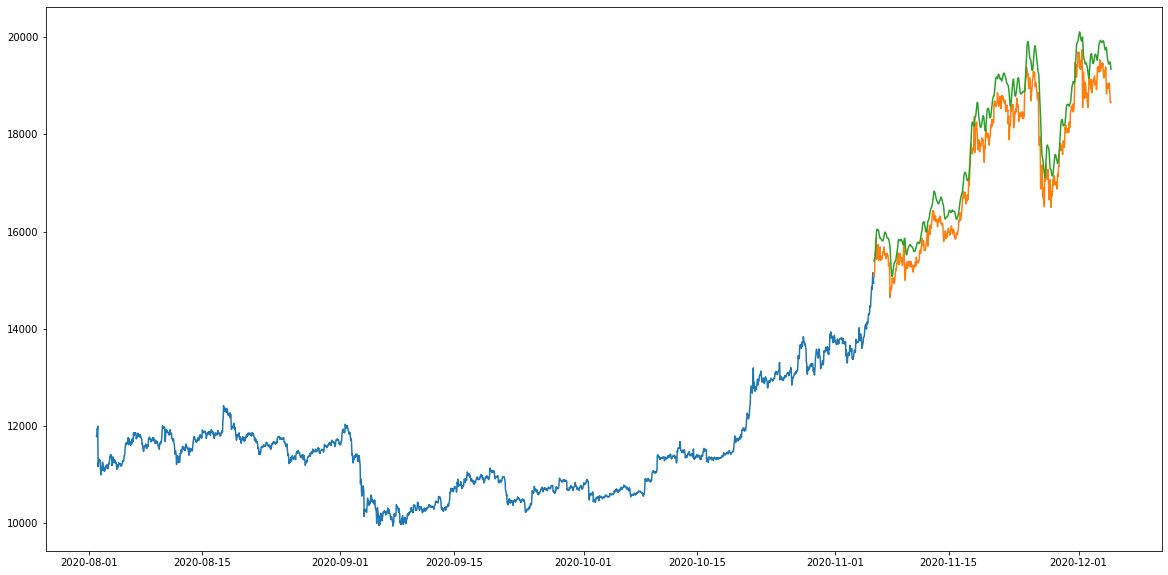

In [5]:
#for plotting
train = new_data[:midpoint]
valid = new_data[midpoint:]
valid['predictions'] = closing_price
plt.plot(train['close'])
plt.plot(valid[['close','predictions']])

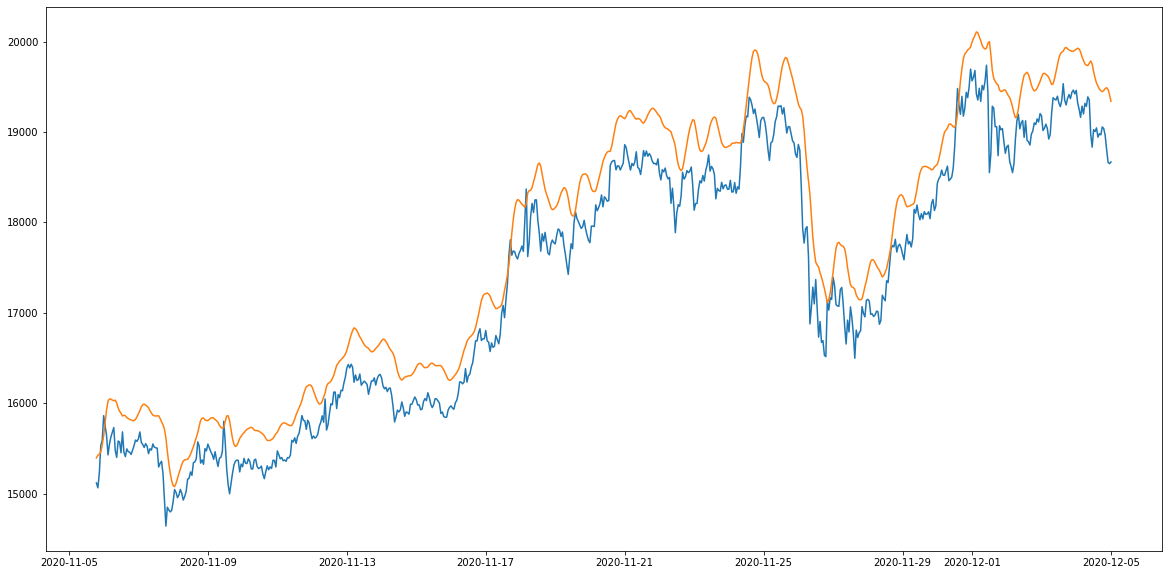

In [6]:
#zoomed in
plt.plot(valid[['close','predictions']])

In [7]:
# use derivative to focus on risk
from scipy.misc import derivative
